In [1]:
import json
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import matplotlib as mpl
import seaborn as sns

In [2]:
mpl.rcParams['figure.dpi'] = 180

In [3]:
def plot_scatter_feature(results_dict, key, figsize=(20, 4)):
    results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2==key}
    diseases = sorted(results.keys())
    fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=figsize)
    for i, disease in enumerate(diseases):
        r = results[disease]
        p_value, x, y, coef_df = round(r['r-squared FDR'], 5), r['groundtruth'], r['predicted'], r['coef_df']
        
        ax1 = axs[0, i]
        ax2 = axs[1, i]
        
        d = pd.DataFrame.from_dict({'groundtruth': x, 'predicted': y})
        sns.regplot(data=d, x='groundtruth', y='predicted', ax=ax1)
        
    
        ax1.set_title(f'{disease}, p-value: {p_value}')
        
        d = pd.DataFrame({'coef': coef_df.iloc[1:]['coef'], 'feature': coef_df.iloc[1:].index})
        sns.barplot(data=d, x='feature', y='coef', ax=ax2)
        plt.xticks(rotation=90)
        

        for ax in [ax1, ax2]:
            ax.set_ylabel('')
            ax.set_xlabel('') 
        if len(diseases) - i != 1:
            ax2.set_xticks([])
        
    plt.subplots_adjust(hspace=.2, wspace=.2)
    plt.tight_layout()

In [4]:
import json
def save_results_dict(filepath, results_dict):
    save_dict = {}
    for disease, d in results_dict.items():
        save_dict[disease] = {}
        for pair, d2 in d.items():
            save_dict[disease][pair] = {}
            for k, val in d2.items():
                if isinstance(val, pd.DataFrame):
                    save_dict[disease][pair][k] = val.to_dict()
                elif 'numpy.ndarray' in str(type(val)) and len(val):
                    save_dict[disease][pair][k] = [float(v) for v in val]
                elif 'numpy.float' in str(type(val)):
                    save_dict[disease][pair][k] = float(val)
                elif isinstance(val, statsmodels.regression.linear_model.RegressionResultsWrapper):
                    pass
                else:
                    save_dict[disease][pair][k] = val
    json.dump(save_dict, open(filepath, 'w'))
    
def load_results_dict(filepath):
    loaded = json.load(open(filepath))
    results_dict = {}
    for disease, d in loaded.items():
        results_dict[disease] = {}
        for pair, d2 in d.items():
            results_dict[disease][pair] = {}
            for k, val in d2.items():
                if k in ['coef_df', 'X', 'y']:
                    results_dict[disease][pair][k] = pd.DataFrame.from_dict(val)
                elif k in ['groundtruth', 'predicted', 'features']:
                    results_dict[disease][pair][k] = np.asarray(val)
                else:
                    results_dict[disease][pair][k] = val
    return results_dict

In [5]:
def get_master_coef_df(results_dict):
    master_coef_df = None
    for disease, results in results_dict.items():
        for k, r in results.items():
            driver, subgene = k.split('_')
            df = r['coef_df'].copy()
            # drop the intercept
            df = df.iloc[1:, :]
            df['feature'] = df.index.to_list()
            df.index = np.arange(df.shape[0])

            # replace 1. fdr with np.nan
            df['FDR'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['FDR'])]
            df['-log10(FDR)'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['-log10(FDR)'])]

            df['driver'] = driver
            df['target'] = subgene
            df['disease'] = disease
            df['model_r2'] = r['r-squared']
            df['model_r2_FDR'] = r['r-squared FDR']

            if master_coef_df is None:
                master_coef_df = df.copy()
            else:
                master_coef_df = pd.concat((master_coef_df, df))
    master_coef_df.index = np.arange(master_coef_df.shape[0])
    
    return master_coef_df

In [6]:
def plot_feat_coef_by_disease(gene, master_coef_df, figsize=(25, 4), feats=None):
    fig, axs = plt.subplots(ncols=len(set(master_coef_df['disease'])), nrows=1, figsize=figsize, sharey=True,
                           sharex=False)
    for i, disease in enumerate(sorted(set(master_coef_df['disease']))):
        ax = axs[i]
        filtered = master_coef_df[master_coef_df['disease']==disease]
        filtered = filtered[filtered['driver']==gene]
        if feats is not None:
            filtered = filtered[[True if c in feats else False for c in filtered['feature']]]

        sns.scatterplot(data=filtered, x='coef', y='-log10(FDR)', hue='feature',
                        legend=None if i!=len(set(master_coef_df['disease']))-1 else True,
                        ax=ax)
        ax.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
        ax.axvline(x=0., linestyle='dotted', color='gray')

        if i == len(set(master_coef_df['disease']))-1:
            plt.legend(bbox_to_anchor=(1.1, 1.0))
        ax.set_title(disease)
#     plt.show()

In [7]:
def plot_aggregate_coefficients_boxplot(master_coef_df, figsize=(10, 4), ylim=(0, 4)):
    # plot aggregate coefficients accross cancer types
    fig, axs = plt.subplots(figsize=figsize)
    p = master_coef_df[master_coef_df['FDR']<=.05].copy()
    p['coef'] = np.abs(p['coef'])
    p = p[p['feature']!='driver_gene_is_pathogenic_germline']

    # rename coef
    p['feature'] = [x for x in p['feature']]

    sns.boxplot(data=p, x='disease', y='coef', hue='feature')
    plt.ylim(ylim)
    plt.legend(bbox_to_anchor=(1.5, 1.0))
    plt.tight_layout()

In [8]:
# aggregated input data for all target genes/protein pairs
combined = pd.read_csv('../data/aggregated_06162021.txt.gz', sep='\t', )
combined

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (14819) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,AAAS_proteome,AAK1_proteome,AATF_proteome,ABCA1_proteome,ABCA2_proteome,ABCB1_proteome,ABCB11_proteome,ABCC2_proteome,ABCC3_proteome,...,methylation_subtype_2,methylation_subtype_3,methylation_subtype_4,methylation_subtype_5,methylation_subtype_6,immune_subtype_1,immune_subtype_2,immune_subtype_3,immune_subtype_4,immune_subtype_5
0,01BR001-T,24.366478,24.512335,25.009167,22.761127,18.747711,NaN,NaN,NaN,19.982433,...,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0
1,01BR008-T,24.394392,24.336012,25.198883,22.507570,19.817547,NaN,NaN,NaN,19.608661,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
2,01BR009-T,24.126891,24.312230,24.822895,23.841045,20.841777,NaN,NaN,NaN,19.515286,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
3,01BR010-T,24.328566,24.399937,24.455721,23.044677,20.980193,NaN,NaN,NaN,20.429545,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
4,01BR015-T,24.606059,24.330728,24.259055,22.052379,19.149462,NaN,NaN,NaN,18.981616,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,TumorOnlyIR01-T,22.770989,23.859305,21.765639,22.120720,20.364479,19.257281,NaN,NaN,22.949869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1254,TumorOnlyIR03-T,22.938051,23.648094,21.663581,22.077940,20.358023,19.586598,NaN,NaN,22.951027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1255,TumorOnlyIR14-T,22.828392,23.731050,21.760472,21.959052,20.375218,19.630542,NaN,NaN,23.019681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,TumorOnlyIR21-T,22.813782,23.775605,21.644840,21.982435,20.291244,19.633217,NaN,NaN,23.008923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### truncating mutation analysis

In [9]:
# load in json dict of model run results
trunc = load_results_dict('../results/model_results_cnv_pur_frame_germ_target_prot.json')

In [10]:
# seperated by disease
trunc.keys()

dict_keys(['BR', 'CO', 'EC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDA', 'ccRCC'])

In [11]:
# each model is indexed by its driver/protein pair
br = trunc['BR']
br.keys()

dict_keys(['ABL1_ABI1', 'ABL1_ABL1', 'ABL1_ABL2', 'ABL1_AHSA1', 'ABL1_ANXA1', 'ABL1_APBB1', 'ABL1_ATR', 'ABL1_BCAR1', 'ABL1_BCR', 'ABL1_BNIP2', 'ABL1_BRCA1', 'ABL1_BTK', 'ABL1_CABLES1', 'ABL1_CABLES2', 'ABL1_CAP1', 'ABL1_CAP2', 'ABL1_CASP9', 'ABL1_CAV1', 'ABL1_CDC42', 'ABL1_CDC73', 'ABL1_CDH2', 'ABL1_CDK1', 'ABL1_CDK5', 'ABL1_CDKN1B', 'ABL1_CEBPB', 'ABL1_CLASP1', 'ABL1_CLASP2', 'ABL1_CLK1', 'ABL1_CRK', 'ABL1_CRKL', 'ABL1_CTNNA1', 'ABL1_CTNNB1', 'ABL1_CTTN', 'ABL1_DDB2', 'ABL1_DDX5', 'ABL1_EGFR', 'ABL1_EMD', 'ABL1_ERCC6', 'ABL1_ESR1', 'ABL1_FOXA1', 'ABL1_FYN', 'ABL1_GPX1', 'ABL1_HCK', 'ABL1_HDAC2', 'ABL1_JAK2', 'ABL1_JUN', 'ABL1_JUNB', 'ABL1_KAT5', 'ABL1_LASP1', 'ABL1_LGALS3', 'ABL1_LYN', 'ABL1_MAP3K8', 'ABL1_MAP4K1', 'ABL1_MAPK11', 'ABL1_MAPK12', 'ABL1_MAPK14', 'ABL1_MAPT', 'ABL1_MDM4', 'ABL1_MET', 'ABL1_MYLK', 'ABL1_NCK1', 'ABL1_NCOA3', 'ABL1_NFAT5', 'ABL1_NFKBIA', 'ABL1_NUMA1', 'ABL1_PAK2', 'ABL1_PDGFRB', 'ABL1_PDK1', 'ABL1_PIK3AP1', 'ABL1_PLCG1', 'ABL1_PLEKHG2', 'ABL1_PLSCR1', 'ABL1

In [13]:
# each model result has the following fields
result = br['TP53_TP53']
result.keys()

dict_keys(['coef_df', 'r-squared', 'r-squared p-value', 'groundtruth', 'predicted', 'features', 'X', 'y', 'r-squared FDR'])

In [14]:
result['coef_df']

,coef,p-value,FDR,-log10(FDR)
Intercept,22.799796,6.745502e-159,2.221757e-158,157.653303
driver_gene_cnv,0.140008,1.268071e-01,2.203094e-01,0.656967
TumorPurity,-0.138682,1.303880e-01,2.253104e-01,0.647219
driver_gene_frameshift_mutation,-0.533785,1.346601e-01,2.315318e-01,0.635389
driver_gene_is_pathogenic_germline,0.000000,NaN,1.000000e+00,0.000000


In [22]:
result['r-squared'], result['r-squared p-value'], result['r-squared FDR']

(0.02563749036134766, 0.11288411470257764, 0.20409659965459723)

In [16]:
result['groundtruth']

array([24.56705979, 24.5018029 , 24.68688885, 22.69975095, 22.76782862,
       23.7373303 , 24.7646247 , 22.47465013, 22.19863395, 22.24849269,
       23.08364533, 26.23801411, 23.31547086, 26.36395051, 21.98943396,
       21.92867416, 21.73171825, 22.64450854, 23.63765513, 21.62740042,
       23.1598578 , 22.65091735, 24.92600552, 22.24246136, 22.01674937,
       24.15625776, 22.71623913, 22.62700112, 21.95611488, 22.76583146,
       22.60676547, 22.10186217, 21.70784683, 22.14548845, 22.18819847,
       25.07949897, 23.30354131, 22.16034729, 22.81258764, 22.09552212,
       22.56481279, 21.62884393, 22.62061215, 25.30698601, 23.30767653,
       22.36760046, 22.6030876 , 23.22831474, 22.5355348 , 21.8511829 ,
       22.64555317, 22.74034306, 22.41672539, 22.51074578, 22.69619805,
       21.86277995, 22.04524764, 22.02627612, 22.80122397, 22.45487221,
       23.82460169, 22.50001057, 23.97898234, 26.29777487, 22.30538251,
       21.03318159, 22.51016981, 22.41613607, 21.86716504, 22.50

In [17]:
result['predicted']

array([22.85362935, 22.99831507, 23.22987125, 22.64924781, 22.72100173,
       22.91673089, 22.96005176, 22.85221987, 22.69751741, 22.70458069,
       23.25306762, 22.58640523, 22.79528223, 23.14800809, 22.61820512,
       22.79641047, 22.37936697, 22.81520062, 22.97772102, 22.77409808,
       22.28706758, 22.96957911, 22.72761529, 22.78102175, 22.65129922,
       23.20306228, 22.6832879 , 22.84216069, 22.57831522, 23.00168999,
       22.80747408, 22.92442981, 21.86690482, 22.54452342, 22.69257695,
       22.74658366, 22.48213878, 22.40304142, 22.57691293, 22.70752755,
       22.96235894, 22.6805882 , 22.8157741 , 22.45672062, 22.38880615,
       22.8311509 , 23.00445327, 22.38339049, 22.69891323, 22.34443576,
       22.74516653, 22.91769999, 22.84060468, 22.8248554 , 23.02982479,
       22.74155193, 22.60100797, 22.83440548, 22.93754355, 22.6131193 ,
       22.9339007 , 22.76039491, 22.94709238, 22.82525366, 23.13599916,
       22.83050034, 22.70133777, 22.51417652, 22.2381883 , 22.83

In [20]:
result['X']

,driver_gene_cnv,TumorPurity,driver_gene_frameshift_mutation,driver_gene_is_pathogenic_germline
01BR001-T,1.684854,1.312782,0.0,0.0
01BR008-T,0.363388,-1.064607,0.0,0.0
01BR009-T,2.369344,-0.709169,0.0,0.0
01BR010-T,-0.305081,0.777569,0.0,0.0
01BR015-T,-0.550510,0.012395,0.0,0.0
...,...,...,...,...
21BR001-T,-0.417892,-0.303339,0.0,0.0
21BR002-T,0.386159,-1.013097,0.0,0.0
21BR010-T,-0.799890,0.107455,0.0,0.0
22BR005-T,-0.111119,0.049610,0.0,0.0


In [21]:
result['y']

,TP53_proteome
01BR001-T,24.567060
01BR008-T,24.501803
01BR009-T,24.686889
01BR010-T,22.699751
01BR015-T,22.767829
...,...
21BR001-T,23.370373
21BR002-T,22.937968
21BR010-T,22.255708
22BR005-T,22.763682


In [23]:
# the master csv for all models trained in one run of the pipeline
trunc_df = pd.read_csv('../results/model_results_cnv_pur_frame_germ_target_prot.txt', sep='\t')

In [24]:
trunc_df

,Unnamed: 0,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
0,0,-0.034225,7.199437e-02,1.367462e-01,0.864085,driver_gene_cnv,ABL1,ABI1,BR,0.012191,2.913434e-01
1,1,-0.010397,5.822843e-01,7.083697e-01,0.149740,TumorPurity,ABL1,ABI1,BR,0.012191,2.913434e-01
2,2,0.000000,NaN,NaN,NaN,driver_gene_frameshift_mutation,ABL1,ABI1,BR,0.012191,2.913434e-01
3,3,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ABL1,ABI1,BR,0.012191,2.913434e-01
4,4,0.179430,6.365821e-11,2.023076e-10,9.693988,driver_gene_cnv,ABL1,ABL1,BR,0.298532,2.121188e-08
...,...,...,...,...,...,...,...,...,...,...,...
378847,378847,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ZNF750,ZNF706,ccRCC,0.017500,2.551888e-01
378848,378848,0.063912,1.978743e-01,3.142604e-01,0.502710,TumorPurity,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01
378849,378849,-0.002489,9.598520e-01,9.759316e-01,0.010581,driver_gene_cnv,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01
378850,378850,0.000000,NaN,NaN,NaN,driver_gene_frameshift_mutation,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01


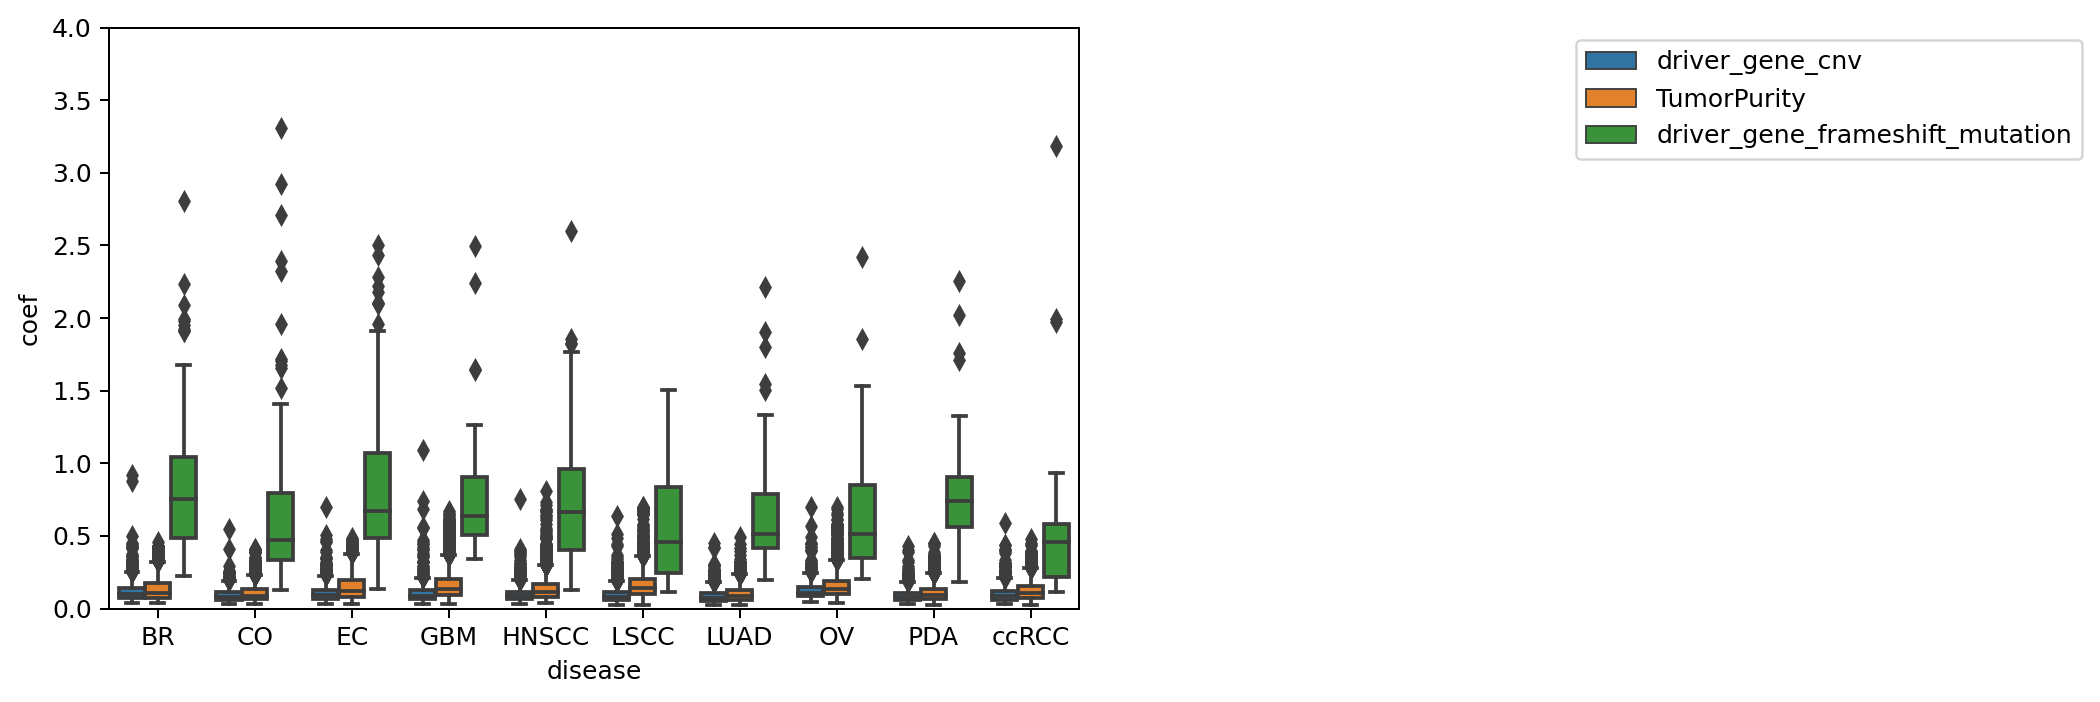

In [25]:
plot_aggregate_coefficients_boxplot(trunc_df)

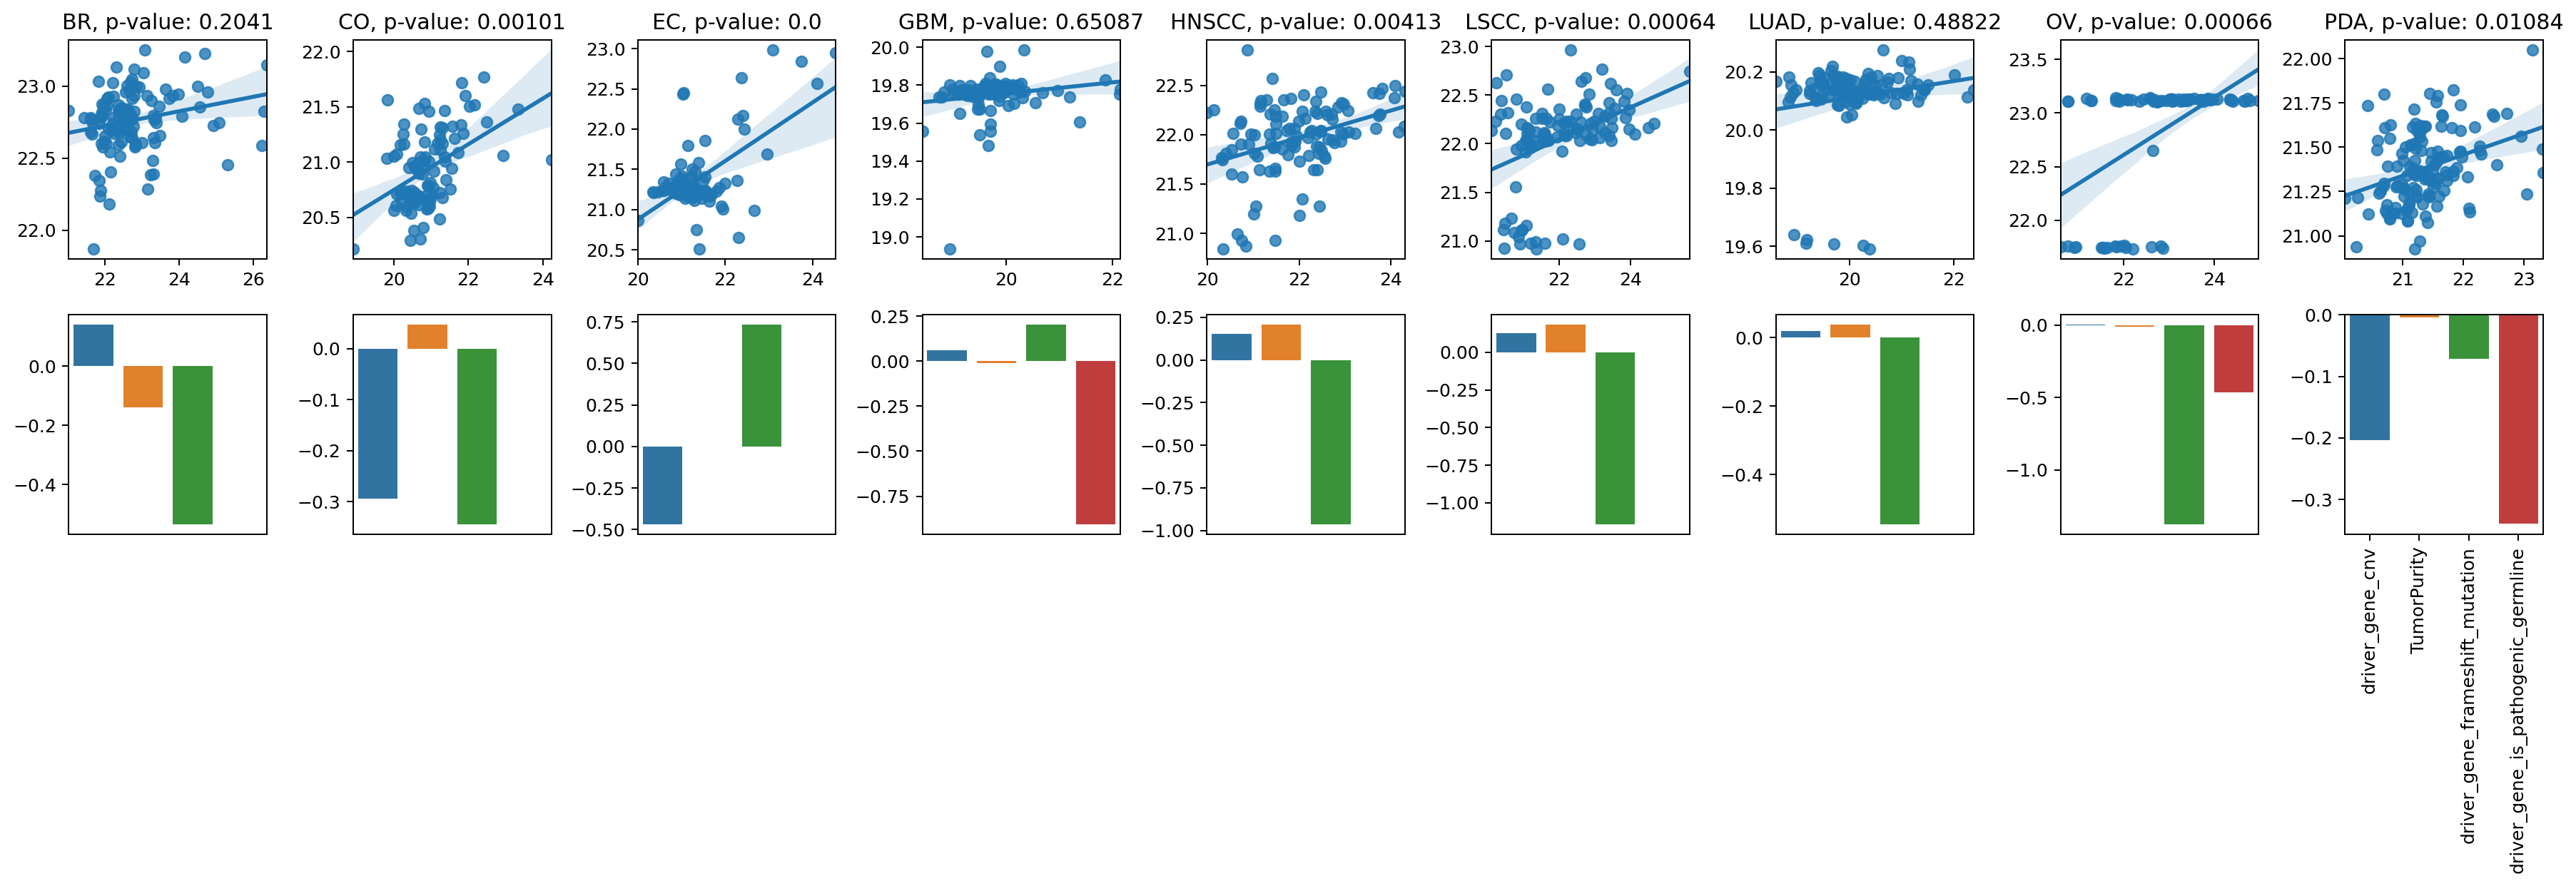

In [26]:
plot_scatter_feature(trunc, 'TP53_TP53', figsize=(20, 7))

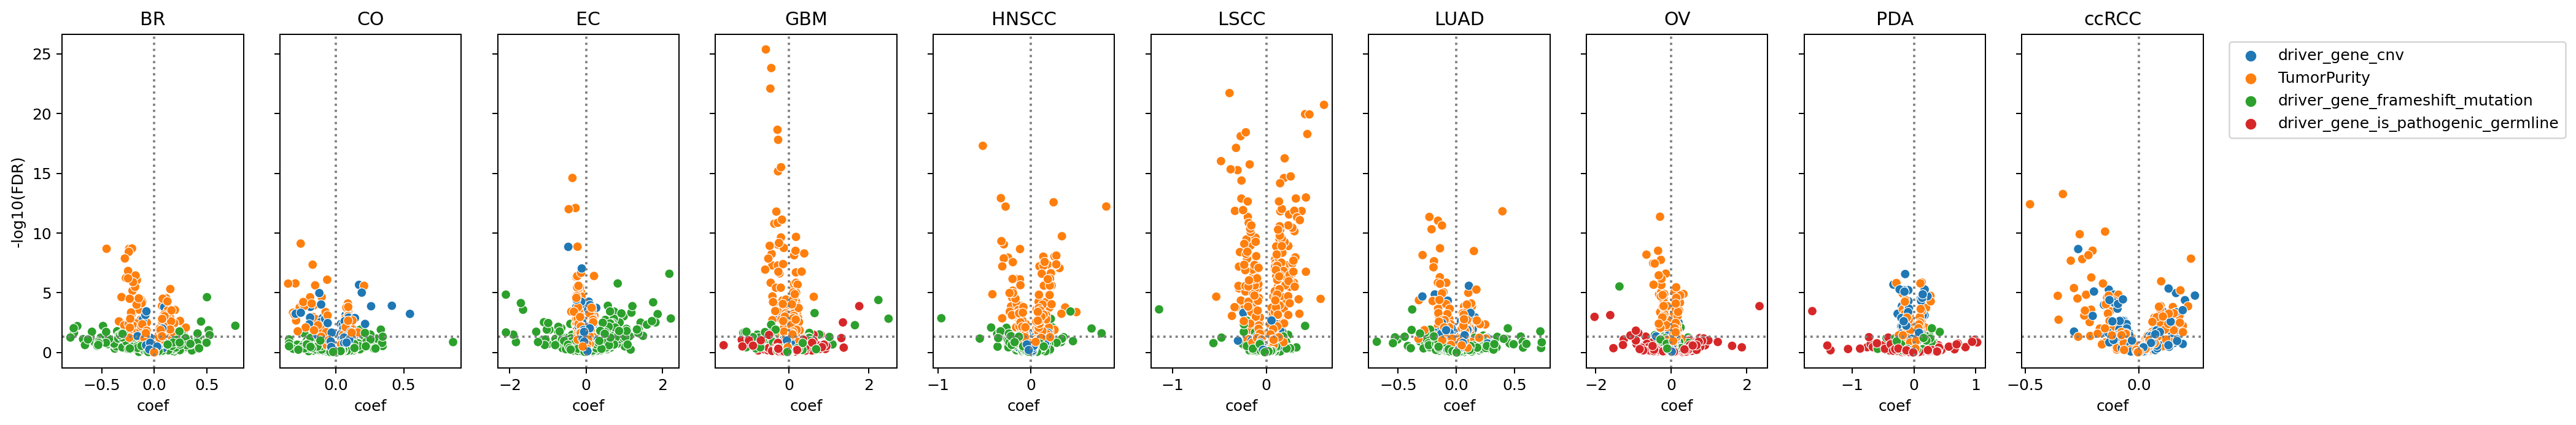

In [27]:
plot_feat_coef_by_disease('TP53', trunc_df)